<div class="alert alert-block alert-warning">
<b>REQUIREMENT:</b>
    Before proceeding, install or update your
    <b><a class="divlink" href="https://astroconda.readthedocs.io">
    AstroConda
    </a></b>
     distribution. The code cells below may not work properly with older versions of AstroConda.
</div>

# ACS/WFC Image Reduction

## Introduction

***

This notebook covers the steps necessary to calibrate Advanced Camera for Surveys (ACS) Wide Field Channel (WFC) observations to produce a distortion-corrected image ready for photometry.

For most observations, reprocessing the raw files with the calibration pipeline is no longer required as the [MAST](http://archive.stsci.edu) archive is now static and any changes to the pipeline or reference files automatically triggers a reprocessing of the data. However, users may wish to reprocess their data with custom reference files.

This notebook is intended for users with a (very!) basic understanding of python and photometry.

You will need approximately **13 GB of space** available for this exercise.

### This tutorial will show you how to...

#### 1. [Calibrate Raw Files](#_calibrate) 

* Query the Calibration Reference Data System ([CRDS](http://www.stsci.edu/hst/observatory/crds/)) for the current best reference files applicable to a given observation
* Update the `*_raw.fits` primary headers with new calibration information
* Retrieve calibration files from CRDS and set up the reference file directory
* Process files with `calacs`

#### 2. [Update the WCS](#_wcs) 

* Update the FLT/FLC file WCS header keywords

## Imports
***

Here we list the Python packages used in this notebook. Links to the documentation for each module is provided for convenience.

| Package Name     | module           | docs          | used for    |
|------------------|:-----------------|:-------------:|:------------|
| `os`             | `system`           | <a class="divlink" href="https://docs.python.org/2/library/os.html#os.system">link</a>|command line input|
| `os`             | `environ`          | <a class="divlink" href="https://docs.python.org/2/library/os.html#os.environ">link</a>| setting environments |
|`shutil`          | `rmtree`           | <a class="divlink" href="https://docs.python.org/2/library/shutil.html#shutil.rmtree">link</a>| remove directory tree |
|`glob`            | `glob`             | <a class="divlink" href="https://docs.python.org/2/library/glob.html#glob.glob">link</a>| search for files based on Unix shell rules |
|`astroquery.mast` |`Observations`      | <a class="divlink" href="https://astroquery.readthedocs.io/en/latest/mast/mast.html">link</a>| download data from MAST |
|`astropy.io`      | `fits`             | <a class="divlink" href="http://docs.astropy.org/en/stable/io/fits/">link</a>| access and update fits files |
|`astropy.table`   | `Table`            | <a class="divlink" href="http://docs.astropy.org/en/stable/table/">link</a>| constructing and editing in a tabular format |
|`stwcs`           |`updatewcs`         | <a class="divlink" href="https://stwcs.readthedocs.io/en/latest/updatewcs_ui.html">link</a>| update wcs solution |

In [1]:
import os
import shutil
import glob

from astroquery.mast import Observations

from astropy.io import fits
from astropy.table import Table

from stwcs import updatewcs

## Download the Data <a id="_download"></a>
***

Here we download all of the data required for this notebook. This is an important step! Some of the image processing steps require all relevant files to be in the working directory. We recommend working with a brand new directory for every new set of data.

#### [GO Proposal 10775](https://stdatu.stsci.edu/proposal_search.php?mission=hst&id=10775): "An ACS Survey of Galactic Globular Clusters"

For this example, we will only retreive data associated with the Observation ID **J9L960010**. Using the python package `astroquery`, we can access the [MAST](http://archive.stsci.edu) archive. 

We will need to grab the raw files, the telemetry files, and the association file for this observation set.

In [2]:
obs_table = Observations.query_criteria(proposal_id=10775, obs_id='J9L960010')


dl_table = Observations.download_products(obs_table['obsid'],
                                          productSubGroupDescription=['RAW', 'ASN', 'SPT'],
                                          mrp_only=False)

We'll use the packages `os` and `shutil` to put all of these files in our working directory and do a little housekeeping.

In [3]:
for row in dl_table:
    oldfname = row['Local Path']
    newfname = os.path.basename(oldfname)
    os.rename(oldfname, newfname)
    
# Delete the mastDownload directory and all subdirectories it contains.
shutil.rmtree('mastDownload')

Setting our files to variable names for convenience using `glob.glob`.

In [4]:
asn_file = 'j9l960010_asn.fits'
raw_files = glob.glob('*_raw.fits')

## File Information
***
For more information, refer to Section <a class="divlink" href="http://www.stsci.edu/hst/acs/documents/handbooks/currentDHB/acs_Ch23.html">Section 2.2</a> of the ACS Data Handbook.

### Association Files

| Ext    | Name             | Type         | Contains                                               |
|--------|------------------|--------------|:-------------------------------------------------------|
|<b>0</b>| PRIMARY          | (PrimaryHDU) | Meta-data related to the entire file.                  |
|<b>1</b>| ASN (Association)| (BinTableHDU)| Table of files associated with this group.             |

In [5]:
with fits.open(asn_file) as hdulist:
    hdulist.info()

Filename: j9l960010_asn.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      44   ()      
  1  ASN           1 BinTableHDU     25   6R x 3C   [14A, 14A, L]   


### Raw Files (WFC-Specific)

| Ext    | Name             | Type         | Contains                                               |
|--------|------------------|--------------|:-------------------------------------------------------|
|<b>0</b>| PRIMARY          | (PrimaryHDU) | Meta-data related to the entire file.                  |
|<b>1</b>| SCI (Image)      | (ImageHDU)   | WFC2 raw image data.                                   |
|<b>2</b>| ERR (Error)      | (ImageHDU)   | WFC2 error array.                                      |
|<b>3</b>| DQ (Data Quality)| (ImageHDU)   | WFC2 data quality array.                               |
|<b>4</b>| SCI (Image)      | (ImageHDU)   | WFC1 raw image data.                                   |
|<b>5</b>| ERR (Error)      | (ImageHDU)   | WFC1 error array.                                      |
|<b>6</b>| DQ (Data Quality)| (ImageHDU)   | WFC1 data quality array.                               |

In [6]:
with fits.open(raw_files[0]) as hdulist:
    hdulist.info()

Filename: j9l960afq_raw.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     218   ()      
  1  SCI           1 ImageHDU        97   (4144, 2068)   int16 (rescales to uint16)   
  2  ERR           1 ImageHDU        49   ()      
  3  DQ            1 ImageHDU        41   ()      
  4  SCI           2 ImageHDU        97   (4144, 2068)   int16 (rescales to uint16)   
  5  ERR           2 ImageHDU        49   ()      
  6  DQ            2 ImageHDU        43   ()      


## Calibrate Raw Files <a id="_calibrate"></a>

***

Now that we have the `*_raw.fits` files, we can process them with the ACS calibration pipeline `calacs`. 

#### Updating Headers for CRDS

By default, the association file will trigger the creation of a drizzled product. In order to avoid this, we will filter the association file to only include table entries with `MEMTYPE` equal to 'EXP-DTH'. This will remove the 'PROD-DTH' entry that prompts AstroDrizzle.

In [7]:
with fits.open(asn_file, mode='update') as asn_hdu:
    asn_tab = asn_hdu[1].data
    asn_tab = asn_tab[asn_tab['MEMTYPE'] == 'EXP-DTH']

Due to the computationally intense processing required to CTE correct full-frame ACS/WFC images, we have disabled the CTE correction here by default, however it can be turned on by changing the following variable to True:

In [8]:
cte_correct = False

Calibration steps can be enabled or disabled by setting the switch keywords in the primary header to 'PERFORM' or 'OMIT', respectively. Switch keywords  all end with the string `CORR` (e.g., `BLEVCORR` and `DARKCORR`). In this case, we want to update `PCTECORR`.

In [9]:
for file in raw_files:
    
    if cte_correct: 
        value = 'PERFORM'
    else: 
        value = 'OMIT'
        
    fits.setval(file, 'PCTECORR', value=value)

#### Querying CRDS for Reference Files

Before running `calacs`, we need to set some environment variables for several subsequent calibration tasks.

We will point to a subdirectory called `crds_cache/` using the JREF environment variable. The `JREF` variable is used for ACS reference files. Other instruments use other variables, e.g., `IREF` for WFC3.

In [10]:
os.environ['CRDS_SERVER_URL'] = 'https://hst-crds.stsci.edu'
os.environ['CRDS_SERVER'] = 'https://hst-crds.stsci.edu'
os.environ['CRDS_PATH'] = './crds_cache'
os.environ['jref'] = './crds_cache/references/hst/acs/'

The code block below will query CRDS for the best reference files currently available for these datasets, update the header keywords to point "to these new files. We will use the Python package `os` to run terminal commands. In the terminal, the line would be:

    crds bestrefs --files [filename] --sync-references=1 --update-bestrefs
    
...where 'filename' is the name of your fits file.

In [11]:
for file in raw_files:
    command_line_input = 'crds bestrefs --files {:} --sync-references=1 --update-bestrefs'.format(file)
    os.system(command_line_input)

#### Running calacs

Finally, we can run `calacs` on the association file. It will produce `*_flt.fits`. The FLT files have had the default CCD calibration steps (bias subtraction, dark subtraction, flat field normalization) performed.

<div class="alert alert-block alert-info"><b>If the CTE correction is enabled...</b>

   * ...this next step will take a long time to complete. The CTE correction is computationally expensive and will use all of the cores on a machine by default. On an 8 core machine, CTE correcting a full-frame ACS/WFC image can take approximately 15 minutes per RAW file. 
   

   * ...`*_flc.fits` will also be produced.  Otherwise, the FLC files are identical to the FLT files.
</div>

In [12]:
os.system('calacs.e j9l960010_asn.fits');

Selecting an image to plot, depending on whether or not you enabled CTE correction earlier.

In [13]:
if cte_correct:
    fl_fits = 'j9l960a7q_flc.fits'
else:
    fl_fits = 'j9l960a7q_flt.fits'

#### Plotting results

As a check of our calibrated products, we will plot a subsection of one of the input images.

In [15]:
from p_module import plot

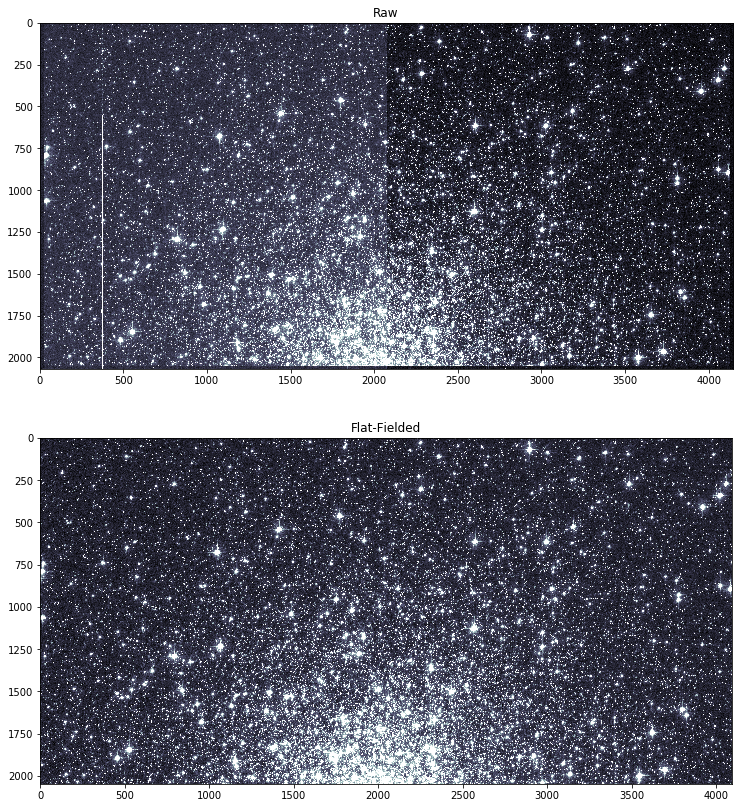

In [16]:
raw_image = fits.getdata('j9l960a7q_raw.fits')
cal_image = fits.getdata(fl_fits)

plot.calib_compare_plot(raw_image, cal_image)

Comparing the FLT calibrated image to the RAW uncalibrated one, we can see that image artifacts have been removed. Most noticeably, hot columns in the bias have been subtracted.

In [17]:
if cte_correct:
    img_files = 'j9l9*a[9-f]q_flc.fits'
else:
    img_files = 'j9l9*a[9-f]q_flt.fits'

updatewcs.updatewcs(img_files, use_db=False)

Using 2015-calibrated VAFACTOR-corrected TDD correction...
- IDCTAB: Distortion model from row 444 for chip 2 : F606W
Using 2015-calibrated VAFACTOR-corrected TDD correction...


- IDCTAB: Distortion model from row 444 for chip 2 : F606W
Using 2015-calibrated VAFACTOR-corrected TDD correction...
- IDCTAB: Distortion model from row 443 for chip 1 : F606W
Using 2015-calibrated VAFACTOR-corrected TDD correction...
- IDCTAB: Distortion model from row 444 for chip 2 : F606W
Using 2015-calibrated VAFACTOR-corrected TDD correction...
- IDCTAB: Distortion model from row 444 for chip 2 : F606W
Using 2015-calibrated VAFACTOR-corrected TDD correction...
- IDCTAB: Distortion model from row 443 for chip 1 : F606W
Using 2015-calibrated VAFACTOR-corrected TDD correction...
- IDCTAB: Distortion model from row 444 for chip 2 : F606W
Using 2015-calibrated VAFACTOR-corrected TDD correction...
- IDCTAB: Distortion model from row 444 for chip 2 : F606W
Using 2015-calibrated VAFACTOR-corrected TDD correction...
- IDCTAB: Distortion model from row 443 for chip 1 : F606W
Using 2015-calibrated VAFACTOR-corrected TDD correction...
- IDCTAB: Distortion model from row 444 for chip 2 : F60

['j9l960afq_flt.fits',
 'j9l960adq_flt.fits',
 'j9l960abq_flt.fits',
 'j9l960a9q_flt.fits']

## Conclusion

***

The FLT and FLC images are not yet suitable for photometry. Before performing any analysis on the images, we still need to remove detector artifacts, cosmic rays, and geometric distortion. [AstroDrizzle](http://drizzlepac.stsci.edu) can be used to do all of these steps and produce a single mosaic image that incorporates all of the individual exposures.

Users who do not use `astrodrizzle` to correct data for distortion will need to apply a pixel area map to their data to correct for the distorted pixel area projected onto the sky before performing photometry. A separate acs notebook guides you through the process of generating and applying a pixel area map.

### For more help:

More details may be found on the [ACS website]() and in the [ACS Instrument]() and [Data Handbooks]().

Please visit the [HST Help Desk](http://hsthelp.stsci.edu). Through the help desk portal, you can explore the *HST* Knowledge Base and request additional help from experts.